In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
POS_TO_LETTER = 'abcdefghjklmnop'
LETTER_TO_POS = {letter: pos for pos, letter in enumerate(POS_TO_LETTER)}

def to_move(pos):
    return POS_TO_LETTER[pos[1]] + str(pos[0] + 1)

def to_pos(move):
    return int(move[1:]) - 1, LETTER_TO_POS[move[0]]

In [3]:
def read_in_chunks(file, size=32768):
    while True:
        data = file.readlines(size)
        if not data:
            break
        yield data

In [4]:
def process_games(games):
    """
    filter draws and store [state, action] pairs for every step in every game
    also add:
                                                                    Channel indices:
        - your turns                                                 0
        - 4 channels history for your turns                          2, 4, 6
        - opponent turns                                             1
        - 4 channels history for opponent turns                      3, 5, 7
        - channel about color (all ones if playing for black)        8

    
    returns:
        states -- nd array of shape [games, 15, 15, 9]
        labels -- nd array of [games, 1]
    """
    states = []
    labels = []
    
    for game in games:
        res, *moves = game.split()
        state = np.zeros((15, 15, 9), dtype=np.uint8)

        player_prev_move = None
        opponent_prev_move = None
        
        if res == 'white':
            player = -1
        elif res == 'black':
            state[..., 8] = 1
            player = 1
        else:
            continue

        for move in moves:
            i, j = to_pos(move)

            if player == 1:
                states.append(np.copy(state))
                labels.append(i * 15 + j)

            if player == 1:
                for s in range(4, 1, -2):
                    np.copyto(state[..., s+2], state[..., s])

                if player_prev_move:
                    m, n = to_pos(player_prev_move)
                    state[..., 2] = 0
                    state[m, n, 2] = 1

                state[i, j, 0] = 1
                player_prev_move = move

            if player == -1:
                for s in range(5, 2, -2):
                    np.copyto(state[..., s+2], state[..., s])

                if opponent_prev_move:
                    m, n = to_pos(opponent_prev_move)
                    state[..., 3] = 0
                    state[m, n, 3] = 1


                state[i, j, 1] = 1
                opponent_prev_move = move

            player = -player
            
    return np.array(states), np.array(labels, dtype=np.uint8)

In [5]:
with open('train-1.renju') as file:
    games = file.readlines(1)
    states, lables = process_games(games)

In [6]:
def print_state(state, label):
    plt.figure(figsize=(15, 10))
    for n, i in enumerate(range(0, 8, 2)):
        plt.subplot(2, 4, n+1)
        plt.imshow(state[..., i], cmap='gray')
    for n, i in enumerate(range(1, 8, 2)):
        plt.subplot(2, 4, n+5)
        plt.imshow(state[..., i], cmap='gray')

    plt.show()
    print(label // 15, label % 15)

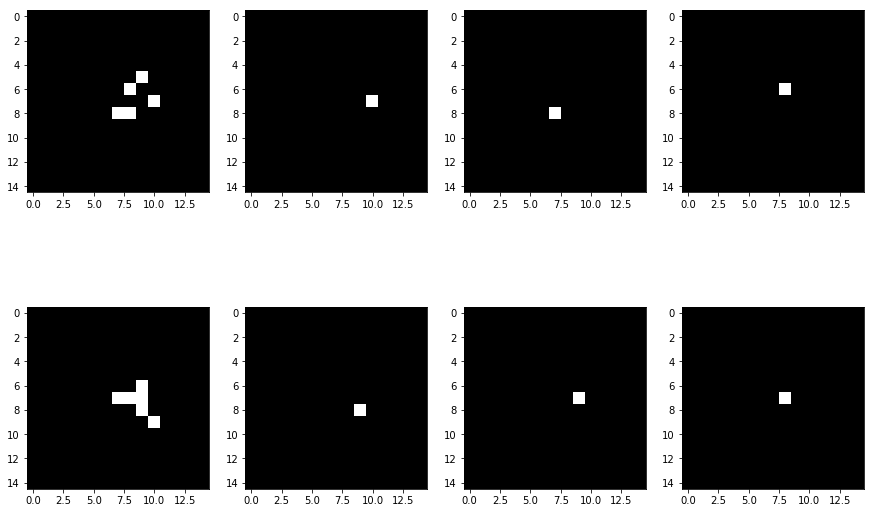

10 11


In [7]:
k = 5
print_state(states[k], lables[k])

In [ ]:
out_states = open('states.dat', 'wb')
out_labels = open('labels.dat', 'wb')


with open('train-1.renju') as file:
    count = 0
    for games in read_in_chunks(file):
        states, labels = process_games(games)
        out_states.write(states.tobytes())
        out_labels.write(labels.tobytes())

        count += 1
        if (count % 600 == 0):
            print(f'{count} chunks DONE')

out_states.close()
out_labels.close()

## Policy network

In [ ]:
class PolicyNet():
    def __init__(self, model_file=None):
        self.graph = tf.Graph()

        if model_file:
            self.load_model(model_file)

        Conv = tf.layers.conv2d
        Relu = tf.nn.relu
        BatchNorm = tf.layers.batch_normalization


    def setup_network(self):
        with self.graph.as_default():
            # variables
            self.input_boards = tf.placeholder(tf.float32, shape=[None, 15, 15, 9], name="input_boards")
            self.labels = tf.placeholder(tf.float32, shape=[None, 1], name='labels')
            self.is_training = tf.placeholder(tf.bool, name="is_training")
            
            # layers
            h_conv1 = Conv(input_boards, filters=16, kernel_size=[3,3], padding='same')
            h_conv2 = Relu(BatchNorm(Conv(h_conv1, filters=16, kernel_size=[3,3], padding='same'), training=self.is_training))
            
            h_conv3 = Conv(h_conv2, filters=32, kernel_size=[3,3], padding='same')
            h_conv4 = Relu(BatchNorm(Conv(h_conv3, filters=32, kernel_size=[3,3], padding='same'), training=self.is_training))
            
            h_conv5 = Conv(h_conv4, filters=64, kernel_size=[3,3], padding='same')
            h_conv6 = Relu(BatchNorm(Conv(h_conv5, filters=64, kernel_size=[3,3], padding='same'), training=self.is_training))
            
            h_conv7 = Conv(h_conv6, filters=1, kernel_size=[1,1], padding='same')
            h_conv7_flat = tf.reshape(h_conv7, [-1, 15 * 15])
            
            self.logits = tf.nn.softmax(h_conv7_flat)
        
            # loss & train step
            log_likelihood_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(log_likelihood_cost)
            
            

    def fit(self, X, y, batch_size=200):
        pass
    
    def predict(self, X):
        pass
    
    def accuracy_score(self, X, y):
        pass
    
    def save_model(self, filepath):
        pass
    
    def load_model(self, filepath):
        pass
            